In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Verify by listing the files in the drive
!ls /content/drive/My\ Drive/

In [ ]:
# import all library we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly.express as px

In [ ]:
# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/train.csv', names=['Sentiment', 'Review'])
test_df = pd.read_csv('/content/drive/MyDrive/test.csv', names=['Sentiment', 'Review'])

In [ ]:
# Display basic info
train_df.info()
print("\n")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentiment  560000 non-null  int64 
 1   Review     560000 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  38000 non-null  int64 
 1   Review     38000 non-null  object
dtypes: int64(1), object(1)
memory usage: 593.9+ KB


In [ ]:
# Display first few rows
print("Train Data Sample:")
train_df.head()

Train Data Sample:


,Sentiment,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [ ]:
print("Test Data Sample:")
test_df.head()

Test Data Sample:


,Sentiment,Review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [ ]:
# Check for missing values
print("Missing values in Train Data:")
train_df.isnull().sum()

Missing values in Train Data:


,0
Sentiment,0
Review,0


In [ ]:
print("Missing values in Test Data:")
test_df.isnull().sum()

Missing values in Test Data:


,0
Sentiment,0
Review,0


In [ ]:
# to see if the dataset balance
train_df['Sentiment'].value_counts()

,count
Sentiment,
1,280000
2,280000


In [ ]:
test_df['Sentiment'].value_counts()

,count
Sentiment,
2,19000
1,19000


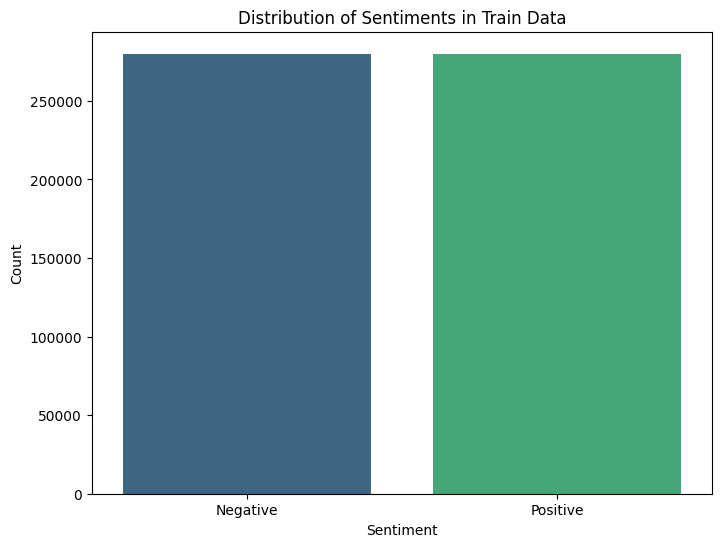

In [ ]:
# Distribution of sentiments in train data
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=train_df, palette='viridis')
plt.title('Distribution of Sentiments in Train Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

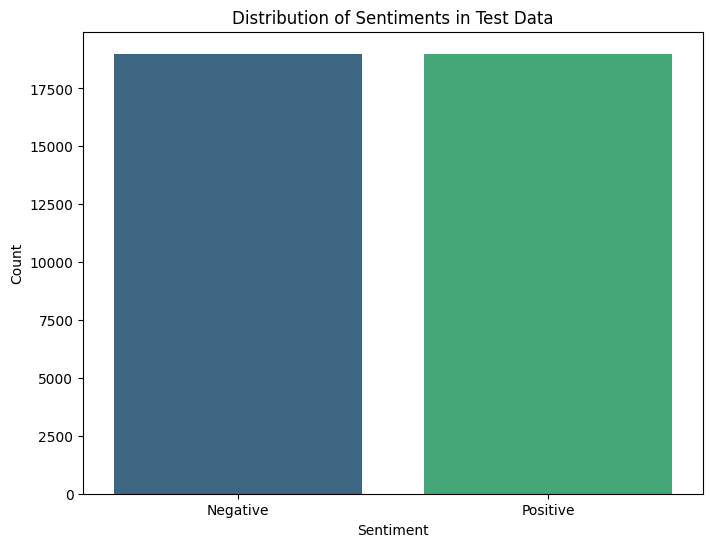

In [ ]:
# Distribution of sentiments in test data
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=test_df, palette='viridis')
plt.title('Distribution of Sentiments in Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [ ]:
# see Text Length
train_df['Review'].str.len().hist()

In [ ]:
test_df['Review'].str.len().hist()

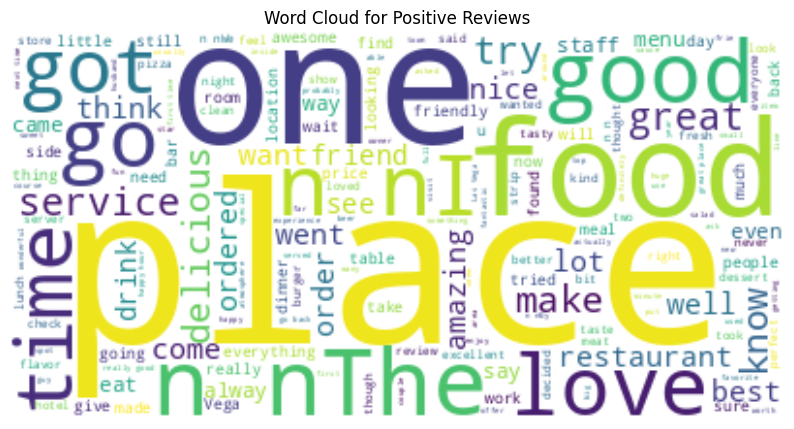

In [ ]:
# Word Cloud for Positive Reviews
text_positive = " ".join(i for i in train_df[train_df['Sentiment'] == 2]['Review'])
wordcloud_positive = WordCloud(background_color="white").generate(text_positive)
plt.figure(figsize=(10, 15))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Reviews')
plt.show()

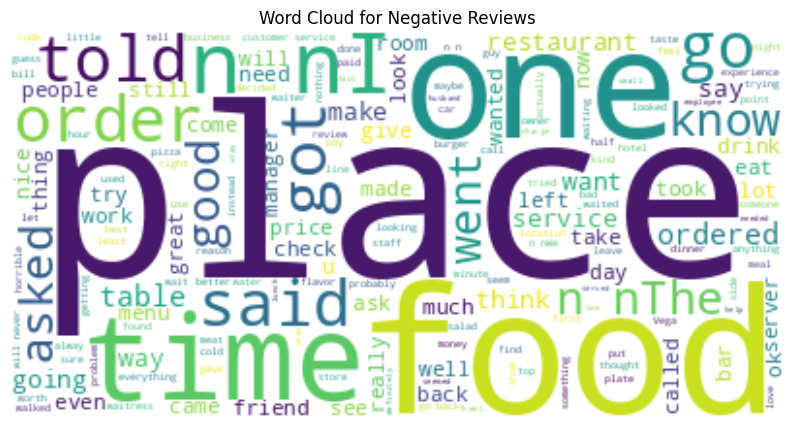

In [ ]:
# Word Cloud for Negative Reviews
text_negative = " ".join(i for i in train_df[train_df['Sentiment'] == 1]['Review'])
wordcloud_negative = WordCloud(background_color="white").generate(text_negative)
plt.figure(figsize=(10, 15))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [ ]:
# Text Cleaning and Stop Words Removal
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r"\b\d+\b", "", text)  # Remove numbers
    text = re.sub('<.*?>+', '', text)  # Remove special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', ' ', text)  # Remove newlines
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002702-\U000027B0"  # Misc symbols
        u"\U000024C2-\U0001F251"  # Misc symbols
    "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  # Remove emojis
    return text

In [ ]:
# Applying the cleaning function
train_df['cleaned_text'] = train_df['Review'].apply(clean_text)
test_df['cleaned_text'] = test_df['Review'].apply(clean_text)

In [ ]:
# remove stop words
train_df['no_sw'] = train_df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test_df['no_sw'] = test_df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [ ]:
print("Train Data Sample:")
train_df.head()

Train Data Sample:


,Sentiment,Review,cleaned_text,no_sw,wo_stopfreq,wo_stopfreq_lem,tokens
0,1,"Unfortunately, the frustration of being Dr. Go...",unfortunately the frustration of being dr gold...,unfortunately frustration dr goldbergs patient...,unfortunately frustration dr goldbergs patient...,unfortunately frustration dr goldberg patient ...,"[unfortunately, the, frustration, of, being, d..."
1,2,Been going to Dr. Goldberg for over 10 years. ...,been going to dr goldberg for over years i th...,going dr goldberg years think one 1st patients...,going dr goldberg years think 1st patients sta...,going dr goldberg year think 1st patient start...,"[been, going, to, dr, goldberg, for, over, yea..."
2,1,I don't know what Dr. Goldberg was like before...,i dont know what dr goldberg was like before ...,dont know dr goldberg like moving arizona let ...,dont know dr goldberg moving arizona let tell ...,dont know dr goldberg moving arizona let tell ...,"[i, dont, know, what, dr, goldberg, was, like,..."
3,1,I'm writing this review to give you a heads up...,im writing this review to give you a heads up ...,im writing review give heads see doctor office...,im writing review give heads see doctor office...,im writing review give head see doctor office ...,"[im, writing, this, review, to, give, you, a, ..."
4,2,All the food is great here. But the best thing...,all the food is great here but the best thing ...,food great best thing wings wings simply fanta...,best thing wings wings simply fantastic wet ca...,best thing wing wing simply fantastic wet caju...,"[all, the, food, is, great, here, but, the, be..."


In [ ]:
print("Test Data Sample:")
test_df.head()

Test Data Sample:


,Sentiment,Review,cleaned_text,no_sw,wo_stopfreq,wo_stopfreq_lem,tokens
0,2,"Contrary to other reviews, I have zero complai...",contrary to other reviews i have zero complain...,contrary reviews zero complaints service price...,contrary reviews zero complaints prices gettin...,contrary review zero complaint price getting t...,"[contrary, to, other, reviews, i, have, zero, ..."
1,1,Last summer I had an appointment to get new ti...,last summer i had an appointment to get new ti...,last summer appointment get new tires wait sup...,last summer appointment new tires wait super l...,last summer appointment new tire wait super lo...,"[last, summer, i, had, an, appointment, to, ge..."
2,2,"Friendly staff, same starbucks fair you get an...",friendly staff same starbucks fair you get any...,friendly staff starbucks fair get anywhere els...,friendly staff starbucks fair anywhere else so...,friendly staff starbucks fair anywhere else so...,"[friendly, staff, same, starbucks, fair, you, ..."
3,1,The food is good. Unfortunately the service is...,the food is good unfortunately the service is ...,food good unfortunately service hit miss main ...,unfortunately hit miss main issue seems kitche...,unfortunately hit miss main issue seems kitche...,"[the, food, is, good, unfortunately, the, serv..."
4,2,Even when we didn't have a car Filene's Baseme...,even when we didnt have a car filenes basement...,even didnt car filenes basement worth bus trip...,even didnt car filenes basement worth bus trip...,even didnt car filenes basement worth bus trip...,"[even, when, we, didnt, have, a, car, filenes,..."


In [ ]:
# Count the Most Frequent Words
cnt = Counter()
for text in train_df['no_sw'].values:
    for word in text.split():
        cnt[word] += 1

In [ ]:
# Display the 10 most common words
most_common_words = cnt.most_common(10)
# Create a DataFrame for plotting
temp = pd.DataFrame(most_common_words, columns=['word', 'count'])
px.bar(temp, x="count", y="word", title='Common Words in Text', orientation='h', width=700, height=700).show()

In [ ]:
# Remove the Most Frequent Words
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])

def remove_freqwords(text):
    """Custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

# Apply to both train_df and test_df
train_df["wo_stopfreq"] = train_df["no_sw"].apply(remove_freqwords)
test_df["wo_stopfreq"] = test_df["no_sw"].apply(remove_freqwords)

In [ ]:
train_df['no_sw'].loc[5]

'wing sauce like water pretty much lot butter hot sauce franks red hot maybe whole wings good size crispy wing sauce could better hot extra hot flavorheat fish sandwich good large portion sides decent'

In [ ]:
train_df['wo_stopfreq'].loc[5]

'wing sauce water pretty much lot butter hot sauce franks red hot maybe whole wings size crispy wing sauce could better hot extra hot flavorheat fish sandwich large portion sides decent'

In [ ]:
test_df['no_sw'].loc[5]

'picture billy joels piano man doubled mixed beer rowdy crowd comedy welcome sing sing unique musical experience found homesteadnnif youre looking grab bite eat beer come serving food brews rock bottom brewery sing sing keeps tummy full listen two amazingly talented pianists take musical requests theyll play anything youd like tips course wanting hear britney spears toto duran duran yep play new oldnnthe crowd makes show make sure come ready good time crowd dead harder guys get reaction youre wanting fun great time perfect place birthday parties especially want embarrass friend guys bring pianos perform little ditty good sport get coveted sing sing bumper sticker wouldnt want thatnndueling pianos brews time shut sing sing'

In [ ]:
test_df['wo_stopfreq'].loc[5]

'picture billy joels piano man doubled mixed beer rowdy crowd comedy welcome sing sing unique musical experience found homesteadnnif youre looking grab bite eat beer come serving brews rock bottom brewery sing sing keeps tummy full listen two amazingly talented pianists take musical requests theyll play anything youd tips course wanting hear britney spears toto duran duran yep play new oldnnthe crowd makes show make sure come ready crowd dead harder guys reaction youre wanting fun perfect birthday parties especially want embarrass friend guys bring pianos perform little ditty sport coveted sing sing bumper sticker wouldnt want thatnndueling pianos brews shut sing sing'

In [ ]:
# Lemmatization
wordnet_lem = WordNetLemmatizer()
train_df['wo_stopfreq_lem'] = train_df['wo_stopfreq'].apply(lambda x: ' '.join([wordnet_lem.lemmatize(word) for word in x.split()]))
test_df['wo_stopfreq_lem'] = test_df['wo_stopfreq'].apply(lambda x: ' '.join([wordnet_lem.lemmatize(word) for word in x.split()]))

In [ ]:
print("Train Data :")
train_df.head()

Train Data :


,Sentiment,Review,cleaned_text,no_sw,wo_stopfreq,wo_stopfreq_lem,tokens
0,1,"Unfortunately, the frustration of being Dr. Go...",unfortunately the frustration of being dr gold...,unfortunately frustration dr goldbergs patient...,unfortunately frustration dr goldbergs patient...,unfortunately frustration dr goldberg patient ...,"[unfortunately, the, frustration, of, being, d..."
1,2,Been going to Dr. Goldberg for over 10 years. ...,been going to dr goldberg for over years i th...,going dr goldberg years think one 1st patients...,going dr goldberg years think 1st patients sta...,going dr goldberg year think 1st patient start...,"[been, going, to, dr, goldberg, for, over, yea..."
2,1,I don't know what Dr. Goldberg was like before...,i dont know what dr goldberg was like before ...,dont know dr goldberg like moving arizona let ...,dont know dr goldberg moving arizona let tell ...,dont know dr goldberg moving arizona let tell ...,"[i, dont, know, what, dr, goldberg, was, like,..."
3,1,I'm writing this review to give you a heads up...,im writing this review to give you a heads up ...,im writing review give heads see doctor office...,im writing review give heads see doctor office...,im writing review give head see doctor office ...,"[im, writing, this, review, to, give, you, a, ..."
4,2,All the food is great here. But the best thing...,all the food is great here but the best thing ...,food great best thing wings wings simply fanta...,best thing wings wings simply fantastic wet ca...,best thing wing wing simply fantastic wet caju...,"[all, the, food, is, great, here, but, the, be..."


In [ ]:
print("Test Data :")
test_df.head()

Test Data :


,Sentiment,Review,cleaned_text,no_sw,wo_stopfreq,wo_stopfreq_lem,tokens
0,2,"Contrary to other reviews, I have zero complai...",contrary to other reviews i have zero complain...,contrary reviews zero complaints service price...,contrary reviews zero complaints prices gettin...,contrary review zero complaint price getting t...,"[contrary, to, other, reviews, i, have, zero, ..."
1,1,Last summer I had an appointment to get new ti...,last summer i had an appointment to get new ti...,last summer appointment get new tires wait sup...,last summer appointment new tires wait super l...,last summer appointment new tire wait super lo...,"[last, summer, i, had, an, appointment, to, ge..."
2,2,"Friendly staff, same starbucks fair you get an...",friendly staff same starbucks fair you get any...,friendly staff starbucks fair get anywhere els...,friendly staff starbucks fair anywhere else so...,friendly staff starbucks fair anywhere else so...,"[friendly, staff, same, starbucks, fair, you, ..."
3,1,The food is good. Unfortunately the service is...,the food is good unfortunately the service is ...,food good unfortunately service hit miss main ...,unfortunately hit miss main issue seems kitche...,unfortunately hit miss main issue seems kitche...,"[the, food, is, good, unfortunately, the, serv..."
4,2,Even when we didn't have a car Filene's Baseme...,even when we didnt have a car filenes basement...,even didnt car filenes basement worth bus trip...,even didnt car filenes basement worth bus trip...,even didnt car filenes basement worth bus trip...,"[even, when, we, didnt, have, a, car, filenes,..."


In [ ]:
from nltk.tokenize import word_tokenize
# Tokenization
def tokenize_text(text):
    return word_tokenize(text)
# Apply tokenization
train_df['tokens'] = train_df['cleaned_text'].apply(tokenize_text)
test_df['tokens'] = test_df['cleaned_text'].apply(tokenize_text)

In [ ]:
print("Train Data :")
train_df.head()

In [ ]:
print("Test Data :")
test_df.head()

In [ ]:
# TF-IDF Vectorization for Feature Extraction
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['wo_stopfreq_lem'])
y_train = train_df['Sentiment']
X_test = vectorizer.transform(test_df['wo_stopfreq_lem'])
y_test = test_df['Sentiment']

In [ ]:
# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

# Naive Bayes Model
naive_bayes_model = ComplementNB()
naive_bayes_model.fit(X_train, y_train)
y_pred_nb = naive_bayes_model.predict(X_test)

In [ ]:
# Print classification reports
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.92      0.93     19000
           2       0.92      0.93      0.93     19000

    accuracy                           0.93     38000
   macro avg       0.93      0.93      0.93     38000
weighted avg       0.93      0.93      0.93     38000

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.90      0.88     19000
           2       0.90      0.86      0.88     19000

    accuracy                           0.88     38000
   macro avg       0.88      0.88      0.88     38000
weighted avg       0.88      0.88      0.88     38000



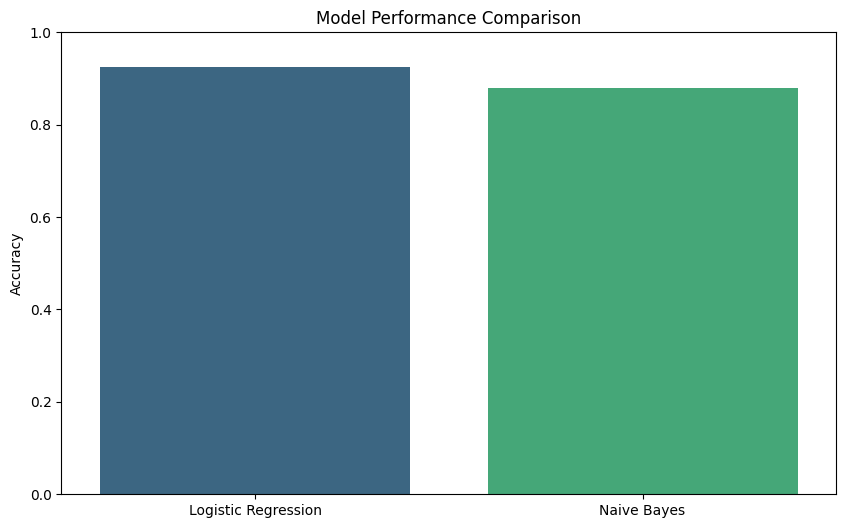

In [ ]:
# Plotting the performance comparison
accuracies = [accuracy_score(y_test, y_pred_logistic), accuracy_score(y_test, y_pred_nb)]
models = ['Logistic Regression', 'Naive Bayes']

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

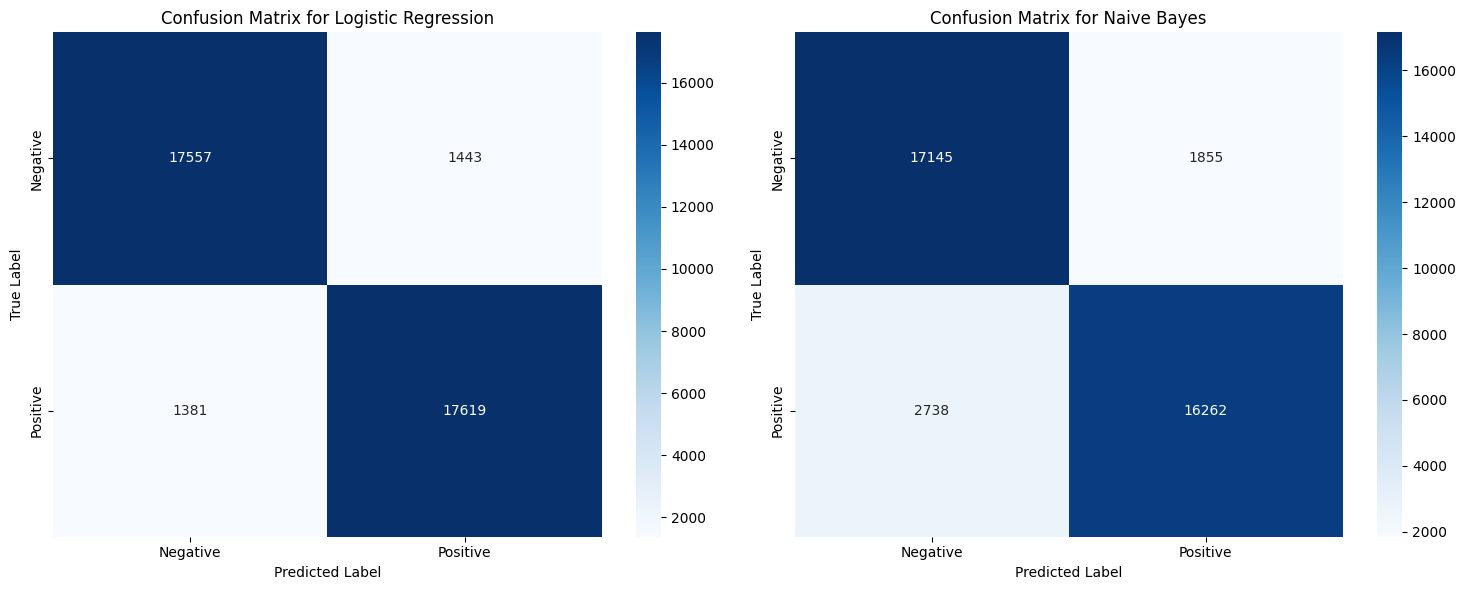

In [ ]:
# Confusion Matrices
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix for Logistic Regression')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
axes[1].set_title('Confusion Matrix for Naive Bayes')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.tight_layout()
plt.show()